## Part 5: Visualizing what convnets learn

### Setup Google Drive

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/IFG/Topicos IA/Trabalho 2 - Cats vs Dogs/notebooks/cats_and_dogs_small_2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

### Preprocessing a single image

In [0]:
from keras.preprocessing import image
import numpy as np

In [0]:
img_path = '/content/drive/My Drive/IFG/Topicos IA/Trabalho 2 - Cats vs Dogs/notebooks/dogs_vs_cats_small/_test/cats/cat.1700.jpg'

In [10]:
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
img_tensor.shape

(1, 150, 150, 3)

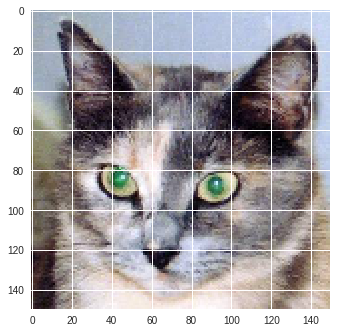

In [11]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

### Instantiating a model from an input tensor and a list of output tensors

In [0]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

### Running the model in predict mode

In [0]:
activations = activation_model.predict(img_tensor)

In [14]:
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 148, 148, 32)

### Visualizing the fourth channel

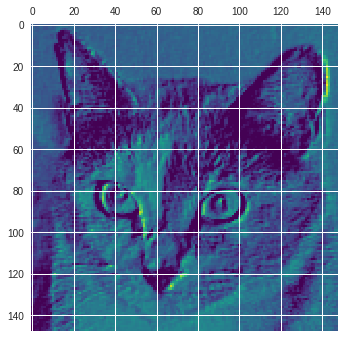

In [15]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

### Visualizing the seventh channel

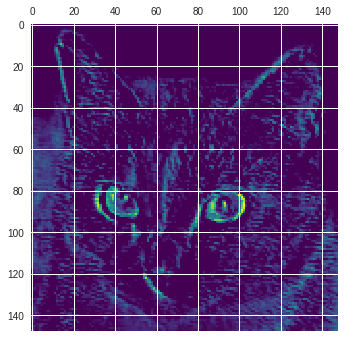

In [16]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

### Visualizing every channel in every intermediate activation

In [0]:
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)

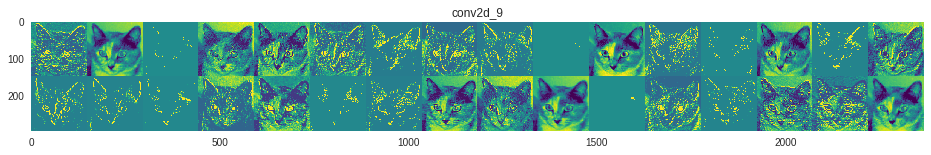

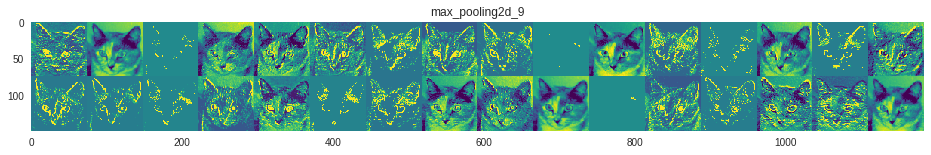

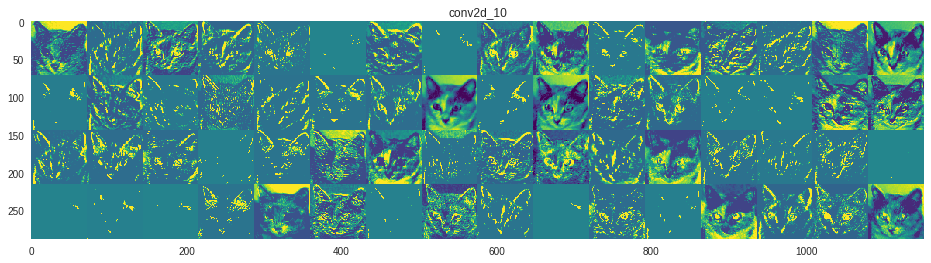

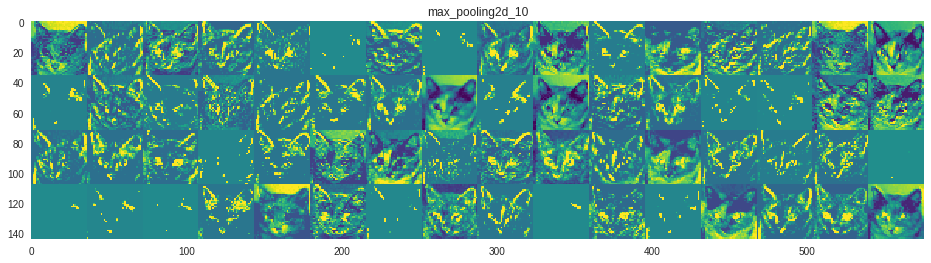

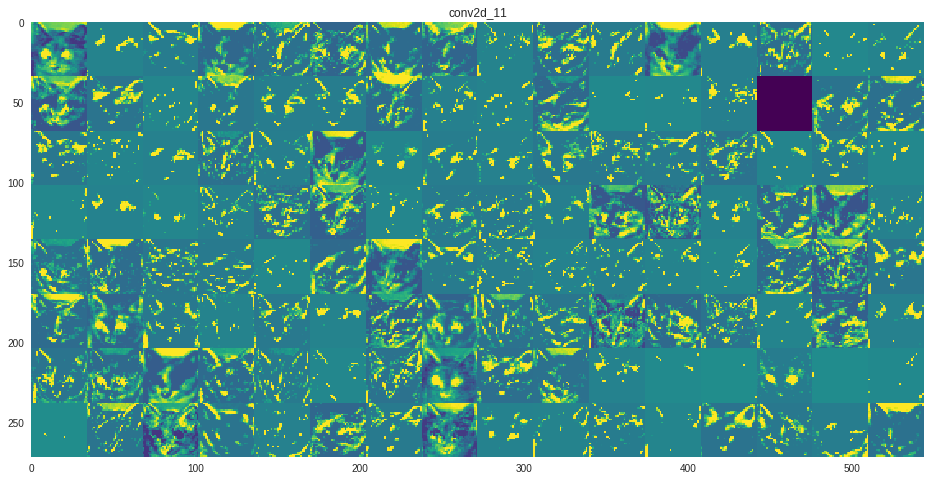

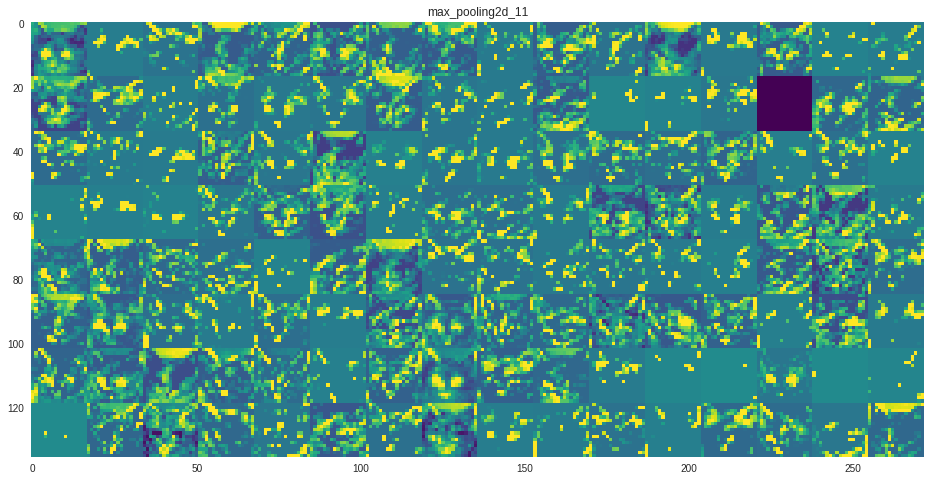

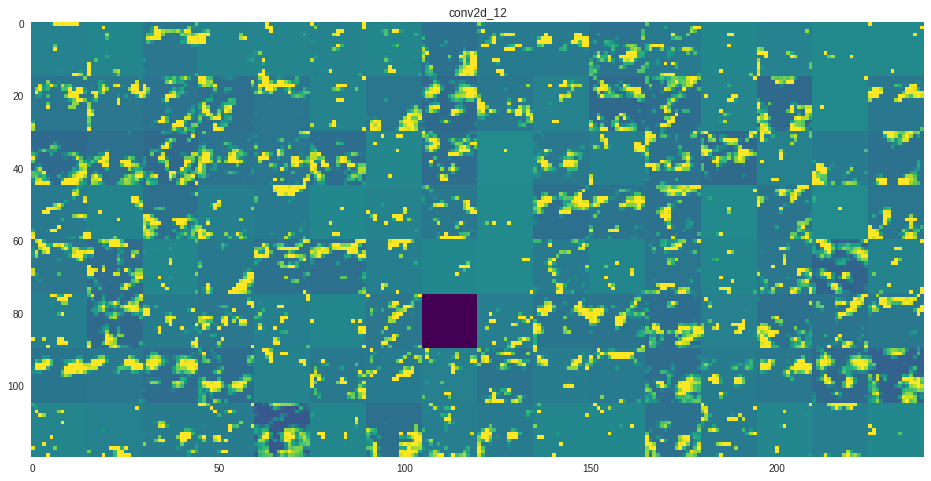

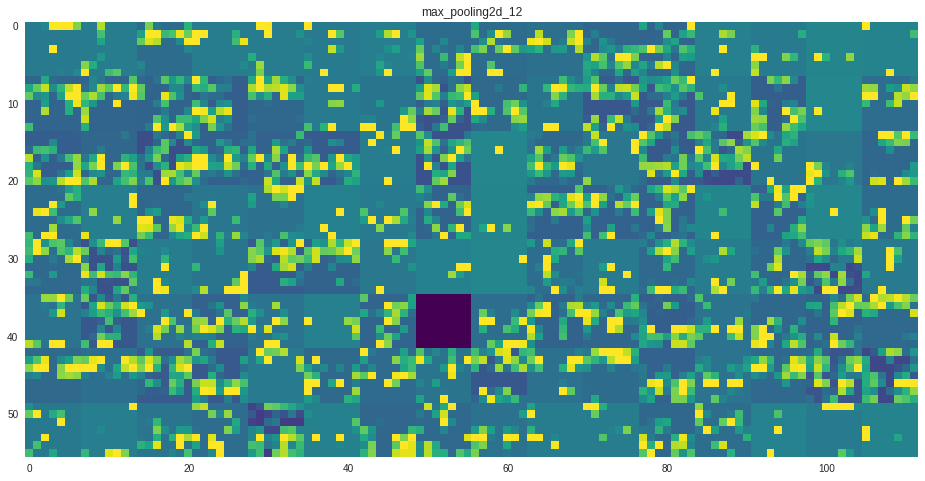

In [39]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
  scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Defining the loss tensor for filter visualization

In [0]:
from keras.applications import VGG16
from keras import backend as K

In [22]:
model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

58892288/58889256 [==============================] - 1s 0us/step


###  Obtaining the gradient of the loss with regard to the input

In [28]:
grads = K.gradients(loss, model.input)[0]
grads

<tf.Tensor 'gradients_1/block1_conv1/convolution_grad/Conv2DBackpropInput:0' shape=(?, ?, ?, 3) dtype=float32>

###  Gradient-normalization trick

In [29]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
grads

<tf.Tensor 'truediv_1:0' shape=(?, ?, ?, 3) dtype=float32>

### Fetching Numpy output values given Numpy input values

In [0]:
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [31]:
loss_value

4796.794

In [32]:
grads_value

array([[[[ 1.11852616e-01,  1.90505624e-01,  8.84057358e-02],
         [ 1.57922313e-01,  2.42282450e-01,  9.83380452e-02],
         [ 5.66190369e-02,  1.55328229e-01,  1.46764126e-02],
         ...,
         [-7.20975129e-03, -2.79366493e-01, -2.60866404e-01],
         [ 2.60559589e-01,  1.55229345e-01,  1.19010076e-01],
         [ 2.64901578e-01,  2.71297485e-01,  2.35150352e-01]],

        [[ 1.95400834e-01,  2.81239390e-01,  1.08379930e-01],
         [ 2.02121466e-01,  2.38192335e-01,  2.33111102e-02],
         [-1.75764322e-01, -2.22814843e-01, -4.00614202e-01],
         ...,
         [ 1.32903636e-01, -3.29404712e-01, -3.81321222e-01],
         [ 7.12258995e-01,  5.82300305e-01,  4.33667004e-01],
         [ 5.66272259e-01,  5.93422949e-01,  4.90224570e-01]],

        [[ 2.17129156e-01,  3.78399611e-01,  1.19779184e-01],
         [ 5.79069555e-01,  6.90436661e-01,  4.03233081e-01],
         [-1.78681955e-01, -3.53318989e-01, -4.81532007e-01],
         ...,
         [ 4.86963481e-0

###  Loss maximization via stochastic gradient descent

In [27]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128
step = 1
for i in range(40):
  loss_value, grads_value = iterate([input_img_data])
  input_img_data += grads_value * step
input_img_data

array([[[[147.54686157, 138.37951579, 148.42110923],
         [146.23498912, 136.19307588, 145.57204678],
         [139.39298913, 142.85047428, 132.65825353],
         ...,
         [143.05263848, 146.04474451, 133.24326051],
         [140.41356435, 148.5352565 , 139.39881894],
         [138.19335288, 136.52375321, 144.99395004]],

        [[151.71169706, 147.96812605, 139.30366975],
         [137.68821931, 146.66993445, 142.76989544],
         [129.94032008, 135.83651125, 120.32001599],
         ...,
         [152.37702582, 138.2389699 , 126.91479572],
         [158.75277452, 141.03315197, 141.19627075],
         [136.74128608, 142.33466457, 136.27318429]],

        [[135.2121371 , 147.38706869, 139.13697195],
         [152.1350154 , 144.97235319, 147.38415783],
         [134.29831019, 131.58342106, 124.61286929],
         ...,
         [143.61555559, 132.27215925, 136.60111796],
         [152.5826385 , 162.32238685, 158.23192383],
         [147.45401725, 153.49821573, 154.63673393]],

###  Utility function to convert a tensor into a valid image

In [0]:
def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  x += 0.5
  x = np.clip(x, 0, 1)
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

### Function to generate filter visualizations

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])
  grads = K.gradients(loss, model.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  iterate = K.function([model.input], [loss, grads])
  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
  step = 1.
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    img = input_img_data[0]
  return deprocess_image(img)

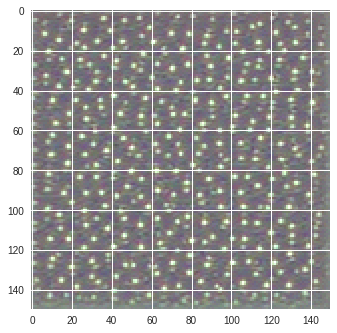

In [35]:
 plt.imshow(generate_pattern('block3_conv1', 0))

###  Generating a grid of all filter response patterns in a layer

In [0]:
layer_name = 'block1_conv1'
size = 64
margin = 5
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

In [0]:
for i in range(8):
  for j in range(8):
    filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
    horizontal_start = i * size + i * margin
    horizontal_end = horizontal_start + size
    vertical_start = j * size + j * margin
    vertical_end = vertical_start + size
    results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img


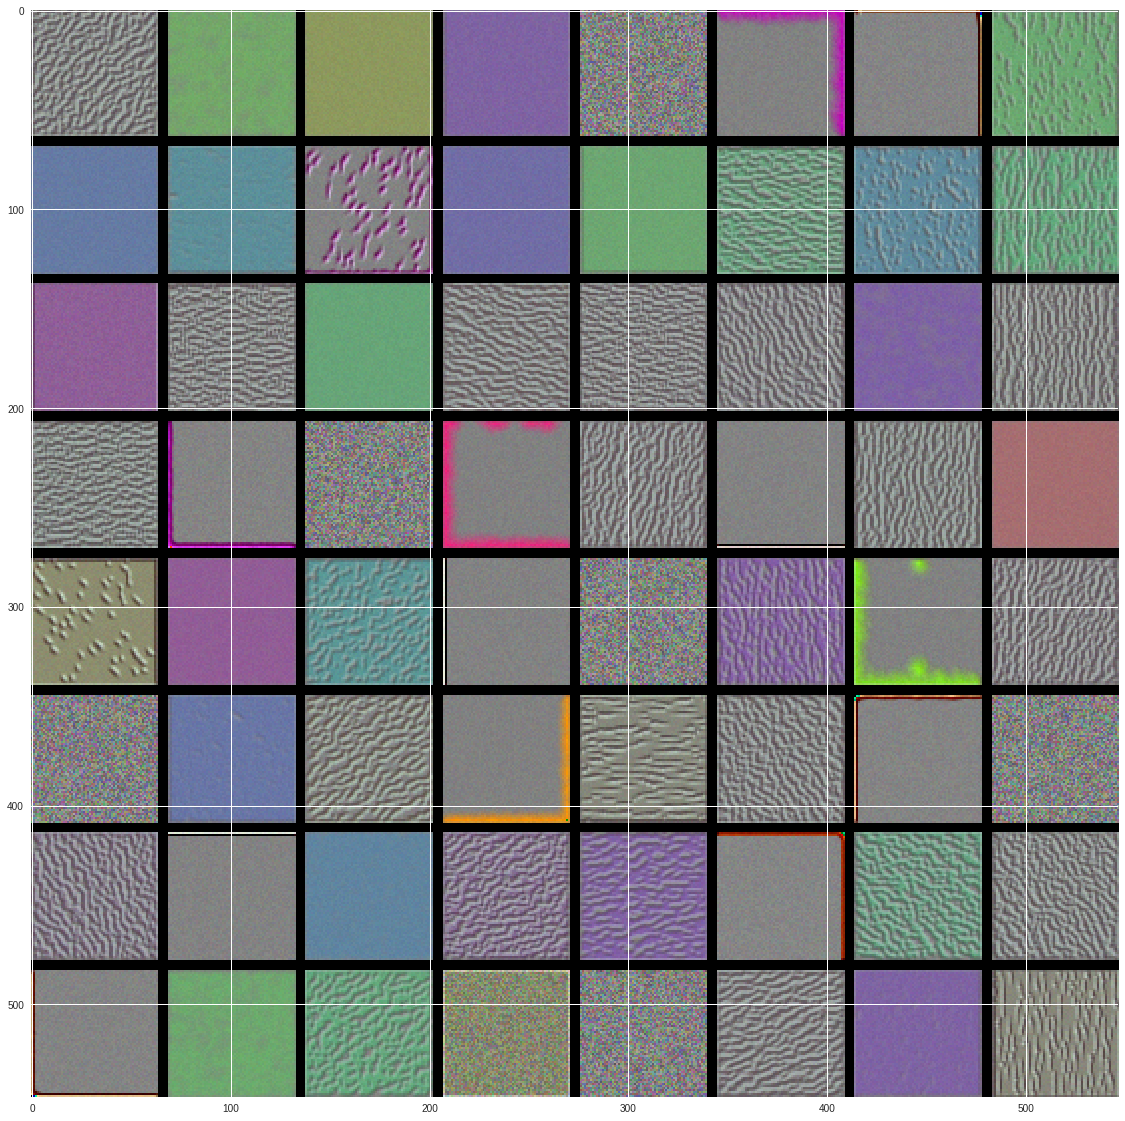

In [38]:
plt.figure(figsize=(20, 20))
plt.imshow(results)